In [1]:
import xgcm
import xarray as xr
import numpy as np
from xbasin import remap_vertical, compute_moc
from matplotlib import pyplot as plt
import cmocean as cm

We open the example data and create 2 grids: 1 for the dataset we have and 1 for the remapped one.
Here '_fr' means *from* and '_to' *to* (i.e. remapped data).

In [2]:
#ds = xr.open_dataset('data/nemo_output_ex.nc')

In [3]:
from xnemogcm import open_nemo_and_domain_cfg

ds = open_nemo_and_domain_cfg(datadir='/home/romain/Documents/Education/PhD/Courses/2019-OC6310/Project/Experiments/EXP_eos00/Rawdata')

In [4]:
metrics_fr = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w']
}
metrics_to = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t_1d', 'e3w_1d']
}
grid_fr = xgcm.Grid(ds, periodic=False, metrics=metrics_fr)
grid_to = xgcm.Grid(ds, periodic=False, metrics=metrics_to)

print(ds)

<xarray.Dataset>
Dimensions:        (axis_nbounds: 2, t: 5, x_c: 21, x_f: 21, y_c: 40, y_f: 40, z_c: 36, z_f: 36)
Coordinates:
  * z_f            (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 31.5 32.5 33.5 34.5
  * t              (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * x_c            (x_c) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19 20
  * y_c            (y_c) int64 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38 39
  * z_c            (z_c) int64 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34 35
  * x_f            (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 17.5 18.5 19.5 20.5
  * y_f            (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 36.5 37.5 38.5 39.5
Dimensions without coordinates: axis_nbounds
Data variables:
    depthw_bounds  (z_f, axis_nbounds) float32 ...
    t_bounds       (t, axis_nbounds) object ...
    woce           (t, z_f, y_c, x_c) float32 ...
    e3w            (t, z_f, y_c, x_c) float32 ...
    deptht_bounds  (z_c, axis_nbounds) float32 ...
    e3t         

We remap

In [5]:
vo_to = remap_vertical(
    ds.vo,
    grid_fr,
    grid_to,
    axis='Z'
)
print(vo_to.coords)

Coordinates:
  * z_c      (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * t        (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * x_c      (x_c) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.5 39.5


## We now compute the overturning stream function

### In depth coordinates

<xarray.DataArray (z_c: 36, y_f: 40)>
array([[-2.88219127e+05,  2.88219127e+05,  3.68144415e+05, ...,
        -8.34750909e+03,  0.00000000e+00,  0.00000000e+00],
       [-2.45077179e+05,  2.45077179e+05,  3.53632861e+05, ...,
        -7.25571657e+03,  0.00000000e+00,  0.00000000e+00],
       [-1.10988109e+05,  1.10988109e+05,  2.91795465e+05, ...,
        -5.82228407e+03,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.09829584e+02, -1.09829584e+02, -3.10642418e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.09740121e+01,  1.09740121e+01,  5.39327099e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * z_c      (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
    t        object 7756-01-01 00:00:00
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.

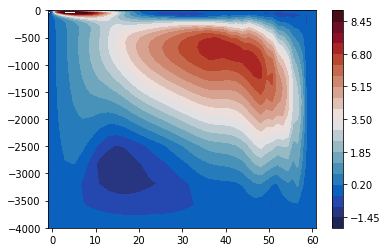

In [6]:
vmax = 9
vmin = -2
levels = np.linspace(vmin, vmax, 21)

moc = compute_moc(vo_to, grid_to)
ctf = plt.contourf(
    ds.gphiv.isel({'x_c':0}),
    -ds.gdepw_1d,
    moc.isel({'t':-1}),
    levels=levels,
    cmap=cm.cm.balance
)
plt.colorbar(ctf)

In [82]:
e3w_sigma = grid_fr.diff(ds.rhop, axis='Z', boundary='extend')
ds['e3w_sigma'] = e3w_sigma
e3t_sigma = grid_fr.diff(grid_fr.interp(ds.rhop, axis='Z', boundary='extend'), axis='Z', boundary='extend')
ds['e3t_sigma'] = e3t_sigma
ds['e3v_sigma'] = grid_fr.interp(ds.e3t_sigma, axis='Y', boundary='extend')

In [87]:
ds['e3t_sigma_1d'] = ds.gdept_1d * 0 + 0.1
ds['e3w_sigma_1d'] = ds.gdepw_1d * 0 + 0.1

In [88]:
metrics_sigma_fr = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t_sigma', 'e3w_sigma', 'e3v_sigma']
}
grid_sigma_fr = xgcm.Grid(ds, metrics=metrics_sigma_fr)

metrics_sigma_to = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t_sigma_1d', 'e3w_sigma_1d']
}
grid_sigma_to = xgcm.Grid(ds, metrics=metrics_sigma_to)

In [109]:
sigmaw_1d = grid_sigma_to.cumsum(ds.e3t_sigma_1d, axis='Z', boundary='fill', fill_value=0)+1024
sigmaw = grid_sigma_fr.cumsum(ds.e3t_sigma, axis='Z', boundary='fill', fill_value=0) + ds.rhop[0,0]
sigmawv = grid_fr.interp(grid_sigma_fr.cumsum(ds.e3t_sigma, axis='Z', boundary='fill', fill_value=0) + ds.rhop[0,0], axis='Y', boundary='extend')

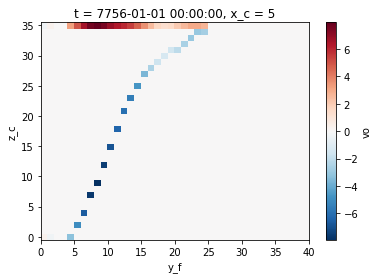

In [97]:
vo_sigma = remap_vertical(
    ds.vo,
    grid_sigma_fr,
    grid_sigma_to,
    axis='Z',
    z_fr = sigmawv,
    z_to = sigmaw_1d
)
vo_sigma[0,:,:,5].plot()

<xarray.DataArray (z_c: 36, y_f: 40)>
array([[ 300195.54902158, -300195.54902158,  -42835.9928541 , ...,
              0.        ,       0.        ,       0.        ],
       [  50040.37335292,  -50040.37335292, -635647.59790785, ...,
              0.        ,       0.        ,       0.        ],
       [ 192661.81741377, -192661.81741377, -634630.20721659, ...,
              0.        ,       0.        ,       0.        ],
       ...,
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [-901777.2285921 ,  901777.2285921 , 1413787.32393634, ...,
              0.        ,       0.        ,       0.        ]])
Coordinates:
  * z_c      (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
    t        object 7756-01-01 00:00:00
  * y_f      (y_f) float64 0.5 1.5 2.

(1028, 1024)

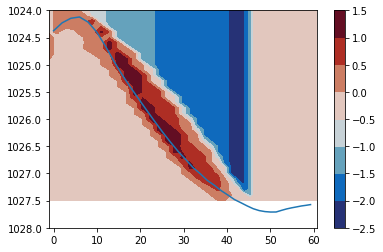

In [92]:
moc_sigma = compute_moc(vo_sigma, grid_sigma_to)

ctf = plt.contourf(
    ds.gphiv.isel({'x_c':0}),
    sigmaw_1d,
    moc_sigma.isel({'t':-1}),
    cmap=cm.cm.balance
)
plt.plot(ds.gphit.isel({'x_c':0})[1:-1], ds.rhop[0,0, 1:-1,1:-1].mean(dim='x_c'))
plt.colorbar(ctf)
plt.ylim(1028,1024)

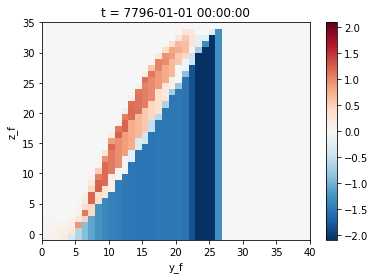

In [91]:
moc_sigma[-1].plot()

In [73]:
sigmaw_1d

<xarray.DataArray (z_f: 36)>
array([1024. , 1024.5, 1025. , 1025.5, 1026. , 1026.5, 1027. , 1027.5,
       1028. , 1028.5, 1029. , 1029.5, 1030. , 1030.5, 1031. , 1031.5,
       1032. , 1032.5, 1033. , 1033.5, 1034. , 1034.5, 1035. , 1035.5,
       1036. , 1036.5, 1037. , 1037.5, 1038. , 1038.5, 1039. , 1039.5,
       1040. , 1040.5, 1041. , 1041.5])
Coordinates:
  * z_f      (z_f) float64 -0.5 0.5 1.5 2.5 3.5 4.5 ... 30.5 31.5 32.5 33.5 34.5

In [38]:
grid_sigma_to.integrate(vo_sigma, axis='X')[0]

<xarray.DataArray (z_c: 36, y_f: 40)>
array([[ 5.37708318e+12, -5.37708318e+12, -5.40932763e+12, ...,
        -7.59380378e+12,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.37708318e+12,  5.37708318e+12,  5.40932763e+12, ...,
         7.59380378e+12,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * z_c      (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
    t        object 7756-01-01 00:00:00
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.5 39.5

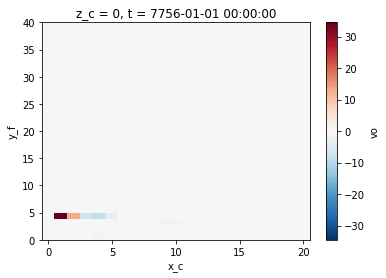

In [108]:
vo_sigma[0,0].plot()

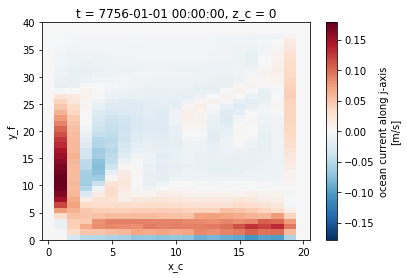

In [103]:
ds.vo[0,0].plot()

# Verification of remapping in density

In [110]:
theta_sigma = remap_vertical(
    ds.thetao,
    grid_sigma_fr,
    grid_sigma_to,
    axis='Z',
    z_fr = sigmaw,
    z_to = sigmaw_1d
)

Vertical integration of heat should be the same

In [114]:
grid_sigma_to.integrate(theta_sigma, axis='Z')

<xarray.DataArray (t: 5, y_c: 40, x_c: 21)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * t        (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * x_c      (x_c) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * y_c      (y_c) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39